$s$

In [3]:
import ipywidgets as widgets
out = widgets.Output()
with out:
    
    %bookmark 'model_dir'
    current_dir = %pwd
    while 'models' in current_dir:
        %cd ..
        current_dir = %pwd
    %bookmark 'base_dir'
    %cd source_code
    out.clear_output()
%run base
%run gui_v6
with out:
    %cd ..
    %cd models/fourbar
    out.clear_output()


In [4]:
m=model()
m.show()

## VEHICLE DYNAMICS MODELING AND SIMULATION TOOL

In [180]:
np.ones((1,3))@np.ones((3,1))

array([[ 3.]])

In [49]:
m.model_tree()

In [3]:
m.bodies[2].q0

rbs_ground.x     0.0
rbs_ground.y     0.0
rbs_ground.z     0.0
rbs_ground.e0    1.0
rbs_ground.e1    0.0
rbs_ground.e2    0.0
rbs_ground.e3    0.0
dtype: float64

In [5]:
m.topology.edges.data(data='joint')

OutMultiEdgeDataView([(rbs_crank, rbs_ground, <constraints.revolute object at 0x0000026036A159E8>), (rbs_crank, rbs_ground, <constraints.rotational_actuator object at 0x0000026036AC37B8>), (rbs_crank, rbs_conn, <constraints.spherical object at 0x00000260369CDB38>), (rbs_conn, rbs_slider, <constraints.universal object at 0x00000260369CD358>), (rbs_slider, rbs_ground, <constraints.translational object at 0x00000260369B8CF8>)])

In [149]:
# -*- coding: utf-8 -*-
"""
Created on Sat May 12 20:41:13 2018

@author: khale
"""


import numpy as np
import scipy as sc

def jacobian_creator(topology):
    
    edgelist = topology.edges(data='joint')
    nodelist = topology.nodes
    
    n_nodes = len(nodelist)
    n_edges = len(edgelist)
            
    jacobian = np.zeros((n_edges+n_nodes,n_nodes),dtype=np.object)
    jacobian.fill(None)
    
    equations = np.zeros((n_edges+n_nodes,1),dtype=np.object)
    
    vel_rhs = np.zeros((n_edges+n_nodes,1),dtype=np.object)
    acc_rhs = np.zeros((n_edges+n_nodes,1),dtype=np.object)
    
    node_index = dict( (node,i) for i,node in enumerate(nodelist) )
        
    for ei,e in enumerate(edgelist):
        (u,v) = e[:2]
        eo    = e[2]
        
        ui = node_index[u]
        vi = node_index[v]
        
        if jacobian[ui+n_edges,ui]==None: jacobian[ui+n_edges,ui] = (u.jac,ui)
        if jacobian[vi+n_edges,vi]==None: jacobian[vi+n_edges,vi] = (v.jac,vi)
                
        jacobian[ei,ui] = (eo.jacobian_i,ui,vi)
        jacobian[ei,vi] = (eo.jacobian_j,vi,ui)
        
        equations[ei,0] = (eo.equations,ui,vi)
        if equations[ui+n_edges,0]==0: equations[ui+n_edges,0]=(u.equations,ui)
        if equations[vi+n_edges,0]==0: equations[vi+n_edges,0]=(v.equations,vi)
        
        
        vel_rhs[ei,0] = ((eo.vel_rhs) if eo.nc==1 else np.zeros((eo.nc,1)))
        vel_rhs[ui+n_edges,0] = (np.array([[0]]) if u.nc==1 else np.zeros((7,1)))
        vel_rhs[vi+n_edges,0] = (np.array([[0]]) if v.nc==1 else np.zeros((7,1)))
        
        acc_rhs[ei,0] = (eo.acc_rhs,ui,vi)
        if acc_rhs[ui+n_edges,0]==0: acc_rhs[ui+n_edges,0]=(u.acc_rhs,ui)
        if acc_rhs[vi+n_edges,0]==0: acc_rhs[vi+n_edges,0]=(v.acc_rhs,vi)
        
      
    def j_mapper(i,q):
        try:
            fun,bi,bj = i
            return fun(q[bi],q[bj])
        except ValueError:
            fun,bi = i
            return fun(q[bi])
        except TypeError:
            return fun(q[bi])

    vectorized_j = np.vectorize(j_mapper,otypes=[np.object],excluded='q')
    
    
    def v_mapper(i):
        try:
            if i.all()==0:
                return i
        except AttributeError:
            return i()

    vectorized_v = np.vectorize(v_mapper,otypes=[np.object])
    
    def a_mapper(i,q,qd):
        try:
            fun,bi,bj = i
            return fun(q[bi],q[bj],qd[bi],qd[bj])
        except ValueError:
            fun,bi = i
            return fun(q[bi],qd[bi])
        except TypeError:
            return fun(q[bi],qd[bi])

    vectorized_a = np.vectorize(a_mapper,otypes=[np.object],excluded=('q','qd'))
    
    return jacobian, equations, vel_rhs, acc_rhs, jacobian.nonzero(), vectorized_j, vectorized_v, vectorized_a


def jacobian_evaluator(jac_blocks,nzi,mapper,q):
    A = jac_blocks.copy()
    A[nzi]=mapper(A[nzi],q=q)
    return sc.sparse.bmat(A)


In [150]:
def nr_kds(j,e,nzi,mapper,q):
    
    A = jacobian_evaluator(j,nzi,mapper,q.values.reshape((4,7)))
    
    b = e.copy()
    b = np.concatenate(mapper(e[e.nonzero()],q=q.values.reshape((4,7))))
    delta_q = sc.sparse.linalg.spsolve(A,-b)
    
    itr=0
    while np.linalg.norm(delta_q)>1e-5:
        
        q=q+delta_q
        
        if itr!=0 and itr%5==0:
            print('Recalculating Jacobian')
            A = jacobian_evaluator(j,nzi,mapper,q.values.reshape((4,7)))
        b = np.concatenate(mapper(e[e.nonzero()],q=q.values.reshape((4,7))))
        delta_q = sc.sparse.linalg.spsolve(A,-b)
        
        itr+=1
        


        if itr>200:
            print("Iterations exceded \n")
            break    
    
    return q


def kds(topology,actuators,time_array):
    q0 = pd.concat([i.q0 for i in topology.nodes])
    j,e,v,a,nzi,mapper = jacobian_creator(topology)
    
    position_df=pd.DataFrame(columns=q0.index)
    position_df.loc[0]=q0
    
    print('\nRunning System Kinematic Analysis:')
    for i,step in enumerate(time_array):
        
        for ac in actuators:
            ac.t=step
        
        
        g=position_df.loc[i]
         
        position_df.loc[i+1]=nr_kds(j,e,nzi,mapper,g)
        
              
        i+=1
        
    return position_df
    

In [155]:
q0=pd.concat([i.q0 for i in m.topology.nodes])

In [152]:
j,e,v,a,nzi,mapper_j,mapper_v, mapper_a = jacobian_creator(m.topology)

In [156]:
mapper_a(a,q=q0.values.reshape((4,7)),qd=q0.values.reshape((4,7)))

AttributeError: 'numpy.ndarray' object has no attribute 'values'

In [102]:
mapper_j(e[e.nonzero()],q=q0.values.reshape((4,7)))

array([ array([[  3.55271368e-15],
       [ -3.55271368e-15],
       [  0.00000000e+00],
       [  4.85722573e-17],
       [ -1.11022302e-16]]),
       array([[-0.90929743]]),
       array([[  1.42108547e-14],
       [  1.06581410e-14],
       [ -1.77635684e-15]]),
       array([[ -3.55271368e-15],
       [  7.33536207e-15],
       [  9.52420783e-17],
       [ -1.52655666e-16]]),
       array([[ -9.52420783e-18],
       [ -2.29934717e-17],
       [ -6.73463194e-17],
       [  6.73463194e-17],
       [ -1.23246909e-16]]),
       array([[ -1.11022302e-16]]),
       array([[ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.]]),
       array([[ 0.]]), array([[ -1.11022302e-16]])], dtype=object)

In [48]:
qs = kds(m.topology,m.actuators,np.linspace(1/500,1,500))


Running System Kinematic Analysis:
Recalculating Jacobian
Recalculating Jacobian
Recalculating Jacobian
Recalculating Jacobian
Recalculating Jacobian
Recalculating Jacobian
Recalculating Jacobian
Recalculating Jacobian
Recalculating Jacobian
Recalculating Jacobian
Recalculating Jacobian
Recalculating Jacobian
Recalculating Jacobian
Recalculating Jacobian


C:\Users\khaled.ghobashy\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:102: SparseEfficiencyWarning:

spsolve requires A be CSC or CSR matrix format



Recalculating Jacobian
Recalculating Jacobian
Recalculating Jacobian
Recalculating Jacobian
Recalculating Jacobian
Recalculating Jacobian
Recalculating Jacobian
Recalculating Jacobian
Recalculating Jacobian
Recalculating Jacobian
Recalculating Jacobian
Recalculating Jacobian
Recalculating Jacobian
Recalculating Jacobian
Recalculating Jacobian
Recalculating Jacobian
Recalculating Jacobian
Recalculating Jacobian
Recalculating Jacobian
Recalculating Jacobian
Recalculating Jacobian
Recalculating Jacobian
Recalculating Jacobian
Recalculating Jacobian
Recalculating Jacobian
Recalculating Jacobian
Recalculating Jacobian
Recalculating Jacobian
Recalculating Jacobian
Recalculating Jacobian
Recalculating Jacobian
Recalculating Jacobian
Recalculating Jacobian
Recalculating Jacobian
Recalculating Jacobian
Recalculating Jacobian
Recalculating Jacobian
Recalculating Jacobian
Recalculating Jacobian
Recalculating Jacobian
Recalculating Jacobian
Recalculating Jacobian
Recalculating Jacobian
Recalculati

In [177]:
i = widgets.IntSlider(value=2,max=500,min=2)
def f(i):
    plt.plot(qs['rbs_crank.x'][0:i],qs['rbs_crank.z'][0:i])
    plt.show()
widgets.interact(f,i=(2,500))


interactive(children=(IntSlider(value=251, description='i', max=500, min=2), Output()), _dom_classes=('widget-…

<function __main__.f>

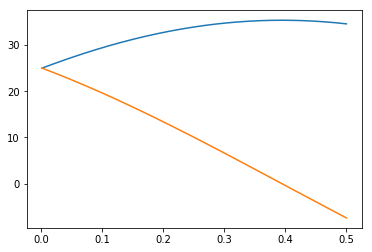

In [168]:
plt.plot(np.linspace(1/500,1,500)[0:250],qs['rbs_crank.z'][0:250])
plt.plot(np.linspace(1/500,1,500)[0:250],qs['rbs_crank.x'][0:250])
plt.show()

In [164]:
qs

,rbs_crank.x,rbs_crank.y,rbs_crank.z,rbs_crank.e0,rbs_crank.e1,rbs_crank.e2,rbs_crank.e3,rbs_ground.x,rbs_ground.y,rbs_ground.z,...,rbs_connecting_rod.e1,rbs_connecting_rod.e2,rbs_connecting_rod.e3,rbs_slider.x,rbs_slider.y,rbs_slider.z,rbs_slider.e0,rbs_slider.e1,rbs_slider.e2,rbs_slider.e3
0,2.500000e+01,0.000000e+00,2.500000e+01,2.798481e-01,3.647052e-01,-1.159169e-01,8.804762e-01,0.0,0.0,0.0,...,-5.869117e-01,-2.397427e-01,7.159172e-01,2.100000e+02,0.000000e+00,2.000000e+01,-2.705981e-01,6.532815e-01,-2.705981e-01,6.532815e-01
1,2.489980e+01,3.552714e-15,2.509980e+01,2.796157e-01,3.629435e-01,-1.164764e-01,8.812039e-01,0.0,0.0,0.0,...,-5.864352e-01,-2.399373e-01,7.163076e-01,2.097595e+02,6.734652e-17,2.000000e+01,-2.705981e-01,6.532815e-01,-2.705981e-01,6.532815e-01
2,2.479920e+01,3.366455e-15,2.519920e+01,2.793822e-01,3.611804e-01,-1.170354e-01,8.819280e-01,0.0,0.0,0.0,...,-5.859602e-01,-2.401310e-01,7.166962e-01,2.095182e+02,6.734640e-17,2.000000e+01,-2.705981e-01,6.532815e-01,-2.705981e-01,6.532815e-01
3,2.469821e+01,3.552714e-15,2.529819e+01,2.791476e-01,3.594158e-01,-1.175939e-01,8.826486e-01,0.0,0.0,0.0,...,-5.854868e-01,-2.403238e-01,7.170830e-01,2.092759e+02,6.734639e-17,2.000000e+01,-2.705981e-01,6.532815e-01,-2.705981e-01,6.532815e-01
4,2.459682e+01,3.552714e-15,2.539678e+01,2.789119e-01,3.576498e-01,-1.181519e-01,8.833657e-01,0.0,0.0,0.0,...,-5.850149e-01,-2.405159e-01,7.174680e-01,2.090327e+02,6.734639e-17,2.000000e+01,-2.705981e-01,6.532815e-01,-2.705981e-01,6.532815e-01
5,2.449503e+01,3.552714e-15,2.549497e+01,2.786750e-01,3.558823e-01,-1.187095e-01,8.840792e-01,0.0,0.0,0.0,...,-5.845446e-01,-2.407071e-01,7.178513e-01,2.087887e+02,6.734639e-17,2.000000e+01,-2.705981e-01,6.532815e-01,-2.705981e-01,6.532815e-01
6,2.439286e+01,3.738972e-15,2.559274e+01,2.784370e-01,3.541135e-01,-1.192666e-01,8.847892e-01,0.0,0.0,0.0,...,-5.840758e-01,-2.408974e-01,7.182327e-01,2.085437e+02,6.734638e-17,2.000000e+01,-2.705981e-01,6.532815e-01,-2.705981e-01,6.532815e-01
7,2.429029e+01,1.776357e-15,2.569011e+01,2.781979e-01,3.523432e-01,-1.198233e-01,8.854957e-01,0.0,0.0,0.0,...,-5.836087e-01,-2.410869e-01,7.186123e-01,2.082979e+02,6.734638e-17,2.000000e+01,-2.705981e-01,6.532815e-01,-2.705981e-01,6.532815e-01
8,2.418734e+01,3.366455e-15,2.578706e+01,2.779577e-01,3.505715e-01,-1.203794e-01,8.861986e-01,0.0,0.0,0.0,...,-5.831431e-01,-2.412755e-01,7.189902e-01,2.080512e+02,6.734638e-17,2.000000e+01,-2.705981e-01,6.532815e-01,-2.705981e-01,6.532815e-01
9,2.408400e+01,3.552714e-15,2.588361e+01,2.777164e-01,3.487984e-01,-1.209351e-01,8.868979e-01,0.0,0.0,0.0,...,-5.826792e-01,-2.414633e-01,7.193662e-01,2.078037e+02,6.734648e-17,2.000000e+01,-2.705981e-01,6.532815e-01,-2.705981e-01,6.532815e-01


In [157]:
%timeit jacobian_evaluator(j,nzi,mapper,q0.values.reshape(4,7))

7.62 ms ± 10.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [104]:
ib = m.actuators[0].i_body.q0
jb = m.actuators[0].j_body.q0
m.actuators[0].equations(ib,jb)
m.actuators[0].pos

0.20202020202020202

In [58]:
en = mapper(e[e.nonzero()],q=q0.values.reshape(4,7))

In [63]:
np.concatenate(en)

array([[  7.10542736e-15],
       [ -7.10542736e-15],
       [  1.06581410e-14],
       [  4.16333634e-17],
       [ -1.11022302e-16],
       [ -5.55111512e-17],
       [  1.42108547e-14],
       [  1.42108547e-14],
       [ -1.59872116e-14],
       [ -3.55271368e-15],
       [  6.87549264e-15],
       [ -9.52420783e-17],
       [ -1.52655666e-16],
       [  9.52420783e-18],
       [  2.29934717e-17],
       [  1.62588398e-16],
       [  1.62588398e-16],
       [ -1.00875766e-16],
       [ -1.11022302e-16],
       [  0.00000000e+00],
       [  0.00000000e+00],
       [  0.00000000e+00],
       [  0.00000000e+00],
       [  0.00000000e+00],
       [  0.00000000e+00],
       [  0.00000000e+00],
       [  0.00000000e+00],
       [ -1.11022302e-16]])

In [11]:
qi = m.joints['jcs_C_trans'].i_body.q0
qj = m.joints['jcs_C_trans'].j_body.q0
m.joints['jcs_C_trans'].equations(qi,qj)

array([[  9.52420783e-18],
       [  2.29934717e-17],
       [  1.62588398e-16],
       [  1.62588398e-16],
       [ -1.00875766e-16]])